In [1]:
!pip3 install prophet==1.1.2
!pip3 install neuralprophet[live]

You should consider upgrading via the '/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/bin/python3.8 -m pip install --upgrade pip' command.
  Using cached neuralprophet-0.6.2-py3-none-any.whl (137 kB)
  Using cached pytorch_lightning-1.9.5-py3-none-any.whl (829 kB)
  Using cached plotly_resampler-0.8.3.2-cp38-cp38-manylinux_2_31_x86_64.whl
     |████████████████████████████████| 15.5 MB 3.5 MB/s eta 0:00:01
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached holidays-0.21.13-py3-none-any.whl (378 kB)
  Using cached captum-0.6.0-py3-none-any.whl (1.3 MB)
  Using cached torchmetrics-0.11.4-py3-none-any.whl (519 kB)
     |████████████████████████████████| 12.2 MB 3.1 MB/s eta 0:00:01     |███████████████████████████▊    | 10.6 MB 6.1 MB/s eta 0:00:01
  Using cached torch-1.13.1-cp38-cp38-manylinux1_x86_64.whl (887.4 MB)
     |████████████████████████████████| 17.1 MB 3.4 MB/s eta 0:00:011   |██▏                             | 1.2 MB 4.3 MB/s eta 0:00:04     |██▉   

In [5]:
import pandas as pd
df = pd.read_csv("data/upc_sales.csv")

# Stores
df_stores = pd.read_csv("data/stores.csv")

# DEMO data
df["DATE"] = pd.to_datetime(df["DATE"])
df["WEEK"] = df['DATE'].dt.to_period('W').dt.to_timestamp()

df = pd.merge(df, df_stores, left_on="STOREID", right_on="STORE_ID", how="inner")
df.rename(columns={"RETAILER_ID_x":"RETAILER_ID", "CITY":"PPG"},inplace=True)
df.drop(columns=["RETAILER_ID_y","STORE_NAME","STORE_ID"],inplace=True)

#Group
df_grouped_volume = df.groupby(["UPC","RETAILER_ID","PPG","WEEK"]).agg(
    {"qty":"sum","mean_unit_price_rounded":"mean"}).reset_index()


# df_grouped_volume["mean_unit_price_rounded"] = df_grouped_volume["mean_unit_price_rounded"].apply(lambda x: round(x, 2))

df_grouped_volume.rename(columns={"mean_unit_price_rounded":"mean_unit_price"},inplace=True)
df_grouped_volume.set_index("WEEK",inplace=True)


# UPC list
df_use_case_upcs = pd.read_csv("data/input_upcs - synthetic-usecases.csv")

print(f"No of columns in DEMO --> {len(df.columns)}")


No of columns in DEMO --> 9


# INPUT UPC

In [6]:
MYUPC = 987654321

In [8]:
import numpy as np

df_use_cases_upcs_current = df_use_case_upcs[df_use_case_upcs["UPC"]==MYUPC]
RETAILER_ID = df_use_cases_upcs_current["RETAILER_ID"].values[0]
PPG = df_use_cases_upcs_current["PPG"].values[0]

print(f"Retailer --> {RETAILER_ID}, PPG --> {PPG}")

df_upc_grouped = df_grouped_volume[(df_grouped_volume["UPC"]==MYUPC)
                           &(df_grouped_volume["RETAILER_ID"]==int(RETAILER_ID))
                           &(df_grouped_volume["PPG"]==PPG)]

df_upc = df_upc_grouped[["qty","mean_unit_price"]].copy()

df_upc_prophet = df_upc_grouped[["qty","mean_unit_price"]].copy()
df_upc_prophet.loc[:,"WEEK"] = df_upc_prophet.index
df_upc_prophet.rename(columns={"qty":"y","WEEK":"ds"},inplace=True)

df_upc = df_upc.asfreq('W',method="ffill") #prophet can deal with missing

df_upc["Logqty"] = np.log(df_upc["qty"])

# df.index = df.index.to_timestamp(freq="D")

# df_upc.loc[:,"WEEK"] = df_upc.index


df_upc_prophet

Retailer --> 3, PPG --> COLUMBIA


,y,mean_unit_price,ds
WEEK,,,
2016-12-26,15.0,4.000000,2016-12-26
2017-01-02,186.0,4.495413,2017-01-02
2017-01-09,196.0,4.598291,2017-01-09
2017-01-16,169.0,3.980392,2017-01-16
2017-01-23,169.0,3.967742,2017-01-23
...,...,...,...
2021-05-17,101.0,4.295082,2021-05-17
2021-05-24,129.0,4.303797,2021-05-24
2021-05-31,111.0,4.208955,2021-05-31


In [9]:
df_upc_prophet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2016-12-26 to 2021-06-14
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   y                232 non-null    float64       
 1   mean_unit_price  232 non-null    float64       
 2   ds               232 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2)
memory usage: 7.2 KB


# Neural Prophet

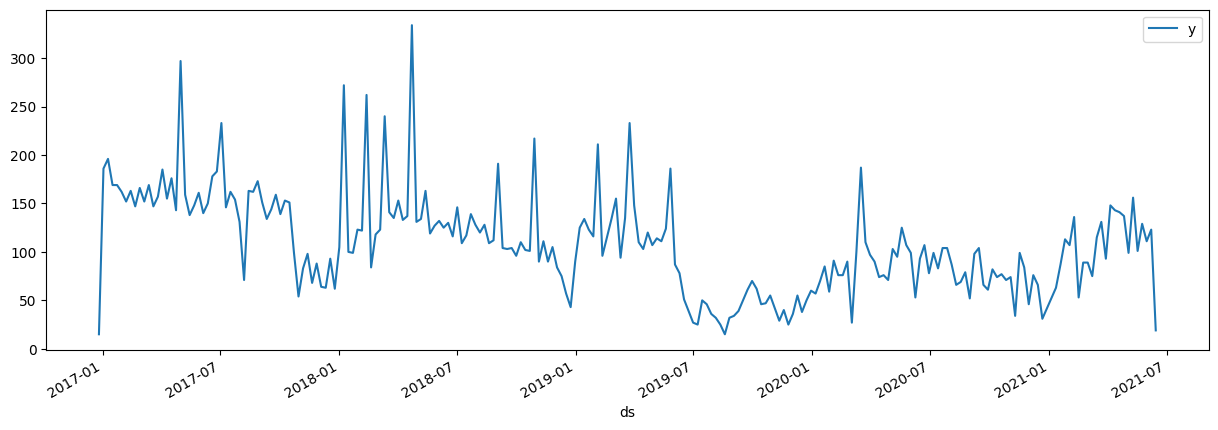

In [10]:
plt = df_upc_prophet.plot(x="ds", y="y", figsize=(15, 5))

Note: Whenever you use a dataset with NeuralProphet, it must be a pandas dataframe with the following format and properties:

Time series column must be named "ds" and contain datetime values.
Value column must be named "y" and contain float values.

# Setting up the model


In [29]:
# Import the NeuralProphet class
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

# Create a NeuralProphet model with default parameters
m = NeuralProphet()
    # Add the autogression
    # n_lags=10,)
# Use static plotly in notebooks
m.set_plotting_backend("matplotlib")

# Fit the model on the dataset (this might take a bit)
metrics = m.fit(df_upc_prophet[["y","ds"]])

Finding best initial lr: 100%|██████████████████████████████████████████████████████| 213/213 [00:00<00:00, 219.00it/s]


Epoch 340: 100%|█| 340/340 [00:00<00:00, 4505.69it/s, loss=0.013, v_num=2, MAE=21.90, RMSE=31.00, Loss=0.0124, RegLoss=


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 171.35it/s]


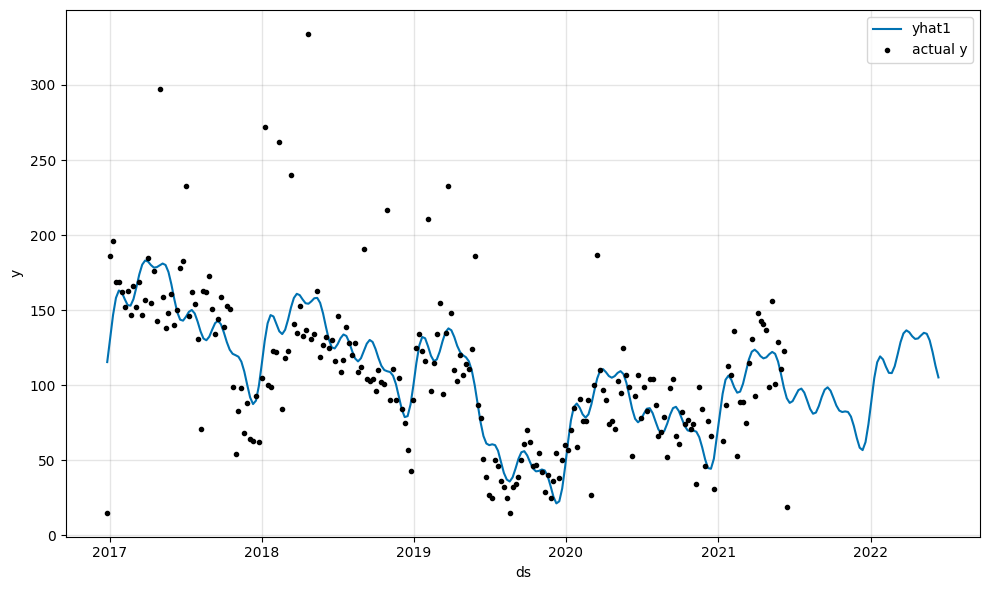

In [30]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
df_future = m.make_future_dataframe(df_upc_prophet[["y","ds"]], n_historic_predictions=True, periods=52)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

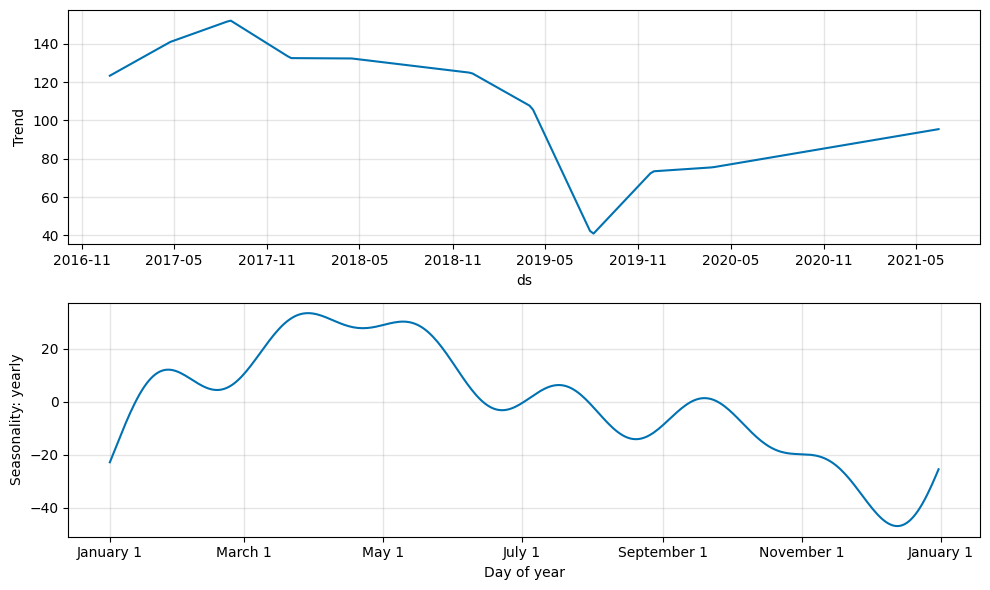

In [19]:
m.plot_parameters(components=["trend", "seasonality"])

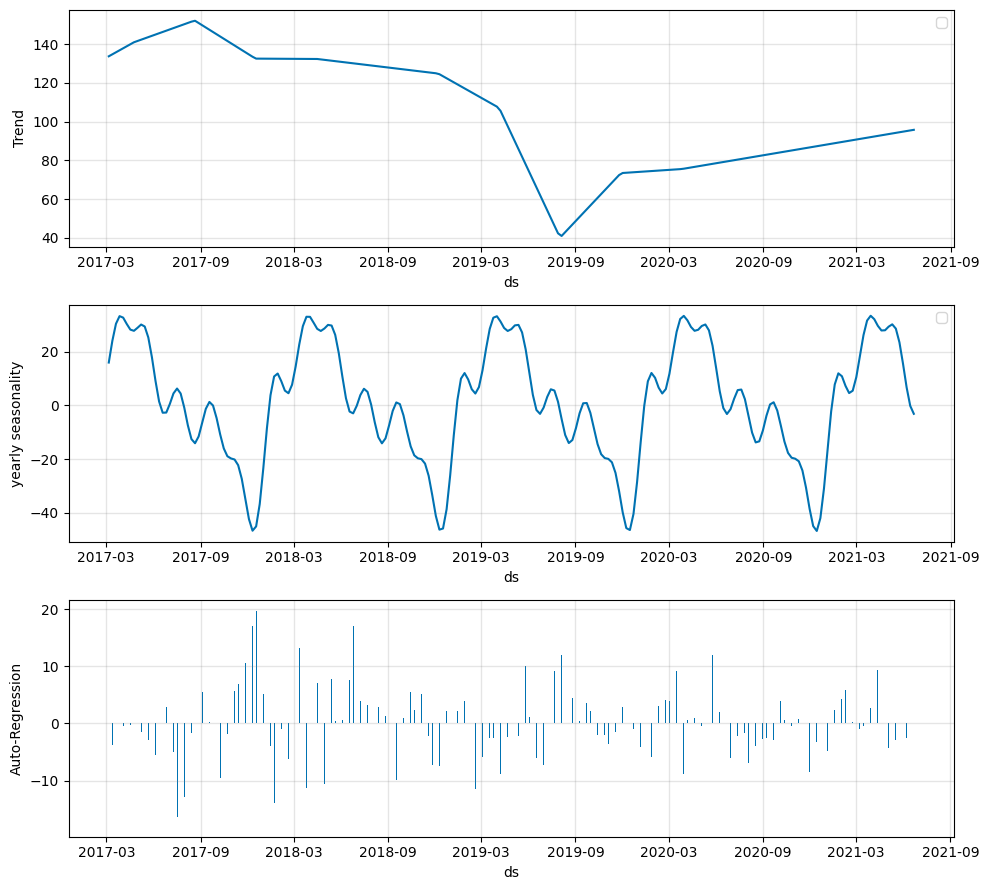

In [20]:
m.plot_components(forecast)

In [21]:
metrics

,MAE,RMSE,Loss,RegLoss,epoch
0,168.444366,202.294418,0.431370,0.0,0
1,166.295074,198.759521,0.422747,0.0,1
2,164.035675,196.516769,0.414084,0.0,2
3,161.575684,195.177536,0.404562,0.0,3
4,158.963593,190.534470,0.394482,0.0,4
...,...,...,...,...,...
341,21.363306,29.447800,0.011816,0.0,341
342,21.363129,29.773987,0.011816,0.0,342
343,21.362911,30.525755,0.011816,0.0,343
344,21.362732,30.528547,0.011816,0.0,344


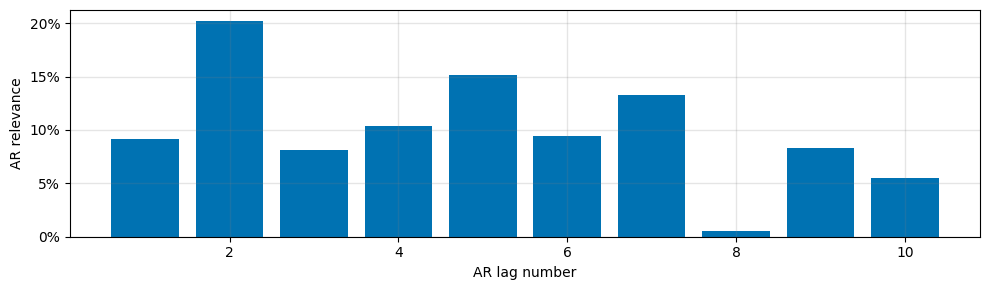

In [22]:
m.plot_parameters(components=["autoregression"])

In [24]:
forecast

,ds,y,yhat1,ar1,trend,season_yearly
0,2016-12-26,15.0,NaN,NaN,NaN,NaN
1,2017-01-02,186.0,NaN,NaN,NaN,NaN
2,2017-01-09,196.0,NaN,NaN,NaN,NaN
3,2017-01-16,169.0,NaN,NaN,NaN,NaN
4,2017-01-23,169.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
230,2021-05-24,129.0,110.449661,-7.540253,94.523506,23.466404
231,2021-05-31,111.0,106.589111,-3.716246,94.837227,15.468131
232,2021-06-07,123.0,99.272263,-2.577597,95.150932,6.698926
233,2021-06-14,19.0,93.890450,-1.416977,95.464645,-0.157220


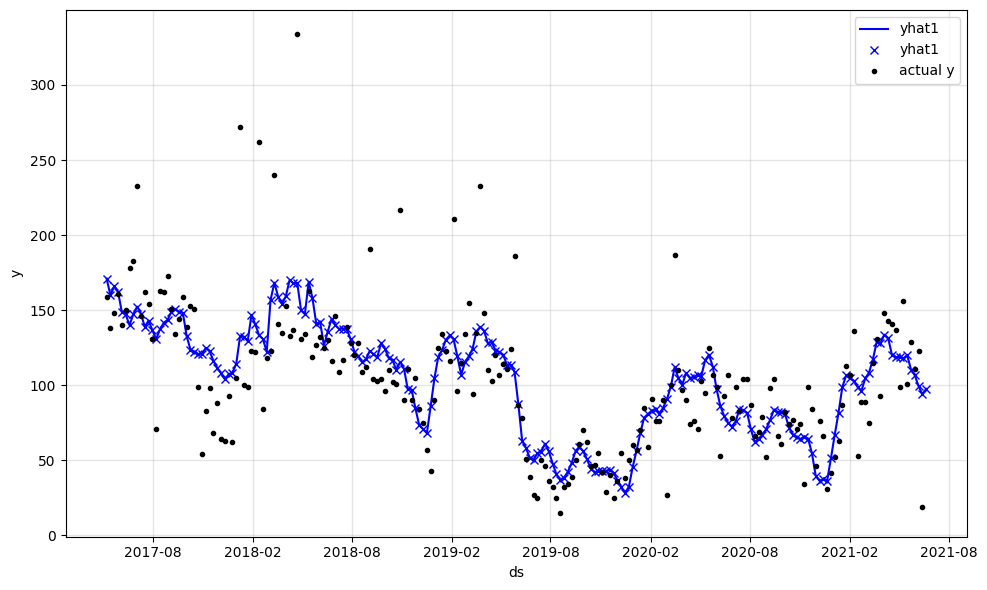

In [27]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast[-9 * 24 :])